# STELLAR CLASSIFICATION

##### The following is a machine learning project aimed at the classification of Stars, Galaxies and Quasar, based on the Sloan Digital Sky Survey DR17  

###### Università degli Studi di Pavia - Ariele Mairani

![unipv logo](unipv-logo.png)

In [2]:
import pickle
import sys
from random import randint

import pandas as pd
import numpy as np
import itertools

from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,label_binarize
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

import seaborn as sns

warnings.filterwarnings('ignore')


## The data

We import the [dataset](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/data) and check its values and null values. Due to the nature of the dataset, we also provide a description and explanation of the different features

1. **obj_ID**:
A unique identifier for each observation in the image catalog. It helps in tracking specific objects across the dataset.

1. **alpha (Right Ascension)**:
The celestial coordinate measuring the angular distance of an object eastward along the celestial equator (in degrees). It specifies the object’s position on the sky horizontally.

1. **delta (Declination)**:
The celestial coordinate measuring the angular distance north or south of the celestial equator (in degrees). It specifies the object’s vertical position in the sky.

1. **u (Ultraviolet filter)**:
The magnitude (brightness) of the object in the ultraviolet range of the photometric system. Lower values indicate higher brightness.

1. **g (Green filter)**:
The magnitude of the object in the green wavelength range of the photometric system.

1. **r (Red filter)**:
The magnitude of the object in the red wavelength range of the photometric system.

1. **i (Near Infrared filter)**:
The magnitude of the object in the near-infrared wavelength range.

1. **z (Infrared filter)**:
The magnitude of the object in the infrared wavelength range.

1. **run_ID**:
A number representing a specific scanning run during data collection by the SDSS.

1. **rerun_ID**:
Indicates how the image data was processed. It’s used to distinguish different processing versions of the same data.

1. **cam_col (Camera column)**:
Specifies the scanline (column) within the camera that captured the object during the scan.

1. **field_ID**:
A number identifying different fields in the sky scanned during the observation run.

1. **spec_obj_ID**:
A unique identifier for objects that have undergone spectroscopic analysis. Multiple observations with the same spec_obj_ID should belong to the same class.

1. **class**:
The target variable representing the type of astronomical object. It can take three possible values:
    - Galaxy
    - Star
    - Quasar  

1. **redshift**:
A measure of how much the light from the object has been stretched due to the expansion of the universe. Higher values indicate that the object is farther away and moving away faster.

1. **plate**:
Identifies the specific plate used in SDSS to capture the observation. SDSS uses plates with optical fibers to capture spectra from different parts of the sky.

1. **MJD (Modified Julian Date)**:
Represents the exact date and time when the observation was taken, expressed as the number of days since November 17, 1858.

1. **fiber_ID**:
Identifies the specific fiber in the plate that was used to point the light at the focal plane for spectroscopic measurement.



In [3]:
data = pd.read_csv('star_classification.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

<Axes: >

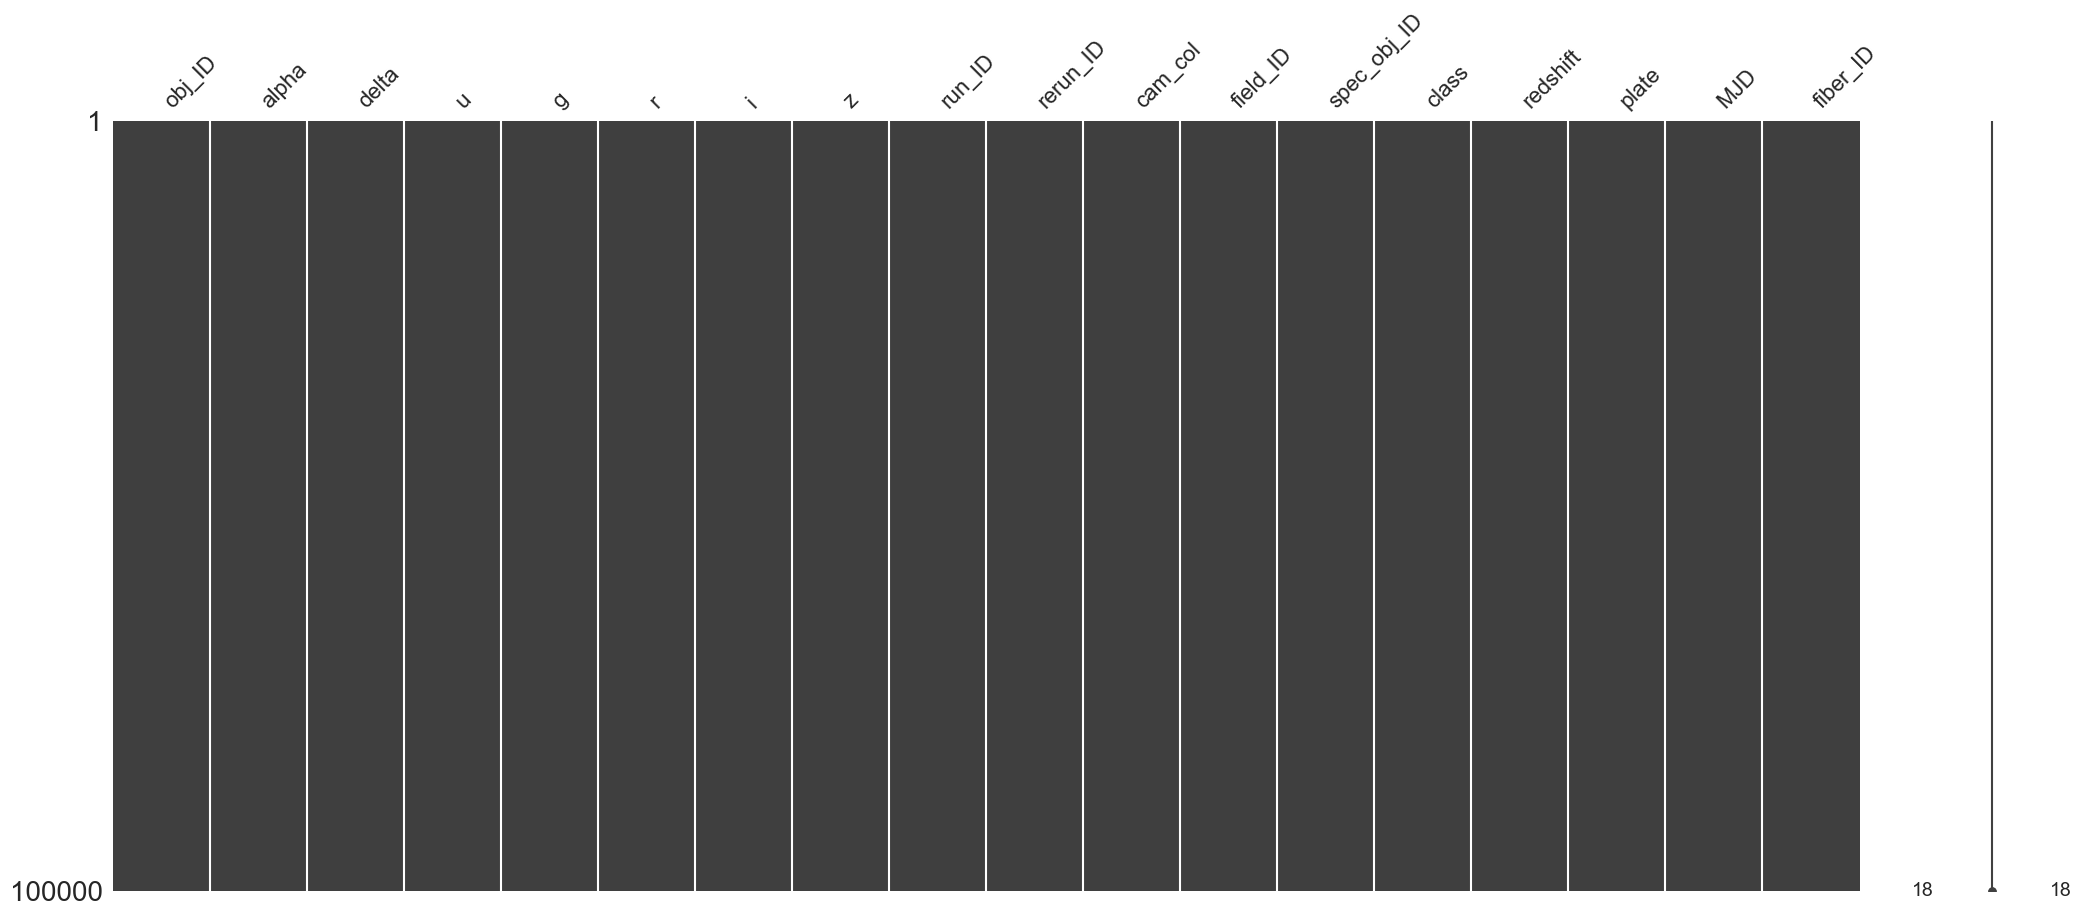

In [4]:
msno.matrix(data)

We can see the data does not have any null values, so there is no need for imputing or for dropping columns, for now.


## Exploratory data analysis

Before defining our transformation pipeline, we perform an exploratory analysis of the data. Since the code for one such exploration needs oly be executed once, we provide it below in form of a Markdown cell. The conclusions gathered from this process will be discussed later.


```python
# ALPHA
data['alpha'].min(), data['alpha'].max()

# DELTA
data['delta'].min(), data['delta'].max()
plt.boxplot(data['delta'])
plt.show()

# U
plt.boxplot(data['u'])
plt.show()
data['u'].min()
a = data['u'][data['u'] != -9999.0].copy()
plt.boxplot(a)
plt.show()

# G
plt.boxplot(data['g'])
plt.show()
data['g'].min()
a = data['g'][data['g'] != -9999.0].copy()
plt.boxplot(a)
plt.show()

# R
plt.boxplot(data['r'])
plt.show()

# I
plt.boxplot(data['i'])
plt.show()

# Z
plt.boxplot(data['z'])
plt.show()
data['z'].min()
a = data['z'][data['z'] != -9999.0].copy()
plt.boxplot(a)
plt.show()

# CLASS
data['class'].value_counts()
tot = data['class'].shape[0]
star = data['class'].eq('STAR').sum()
qso = data['class'].eq('QSO').sum()
galaxy = data['class'].eq('GALAXY').sum()
f'STAR: {round(star*100/tot)}%, QSO: {round(qso*100/tot)}%, GALAXY: {round(galaxy*100/tot)}%'

# REDSHIFT
plt.boxplot(data['redshift'])
data['redshift'].hist(bins=50)
plt.show()

# PLATE
data['plate'].value_counts()
data['plate'].nunique()

# MJD
data['MJD'].value_counts()
data['MJD'].nunique()

# FIBER_ID
data['fiber_ID'].value_counts()
data['fiber_ID'].nunique()
```

During the previous exploration we have determined that:
- alpha and delta are both within the (0, 360) range as they should, since they are in degree
- u, g and z all posses a single row with an outlier of value -9999.0, likely an error
- the labels are unbalanced with the following percentages: 
    - Star: 22%
    - Quasar: 19%
    - Galaxy: 59%
- the redshift has a long tail stretching to higher and higher redshifts, suggesting that though the bulk of the data refers to "nearby" celestial bodies, a significant albeit small fraction is derived from distant and fast receding ones

Furthermore, we provide a compact visualization of the plots utilized during the exploration, without the outliers for readability's sake

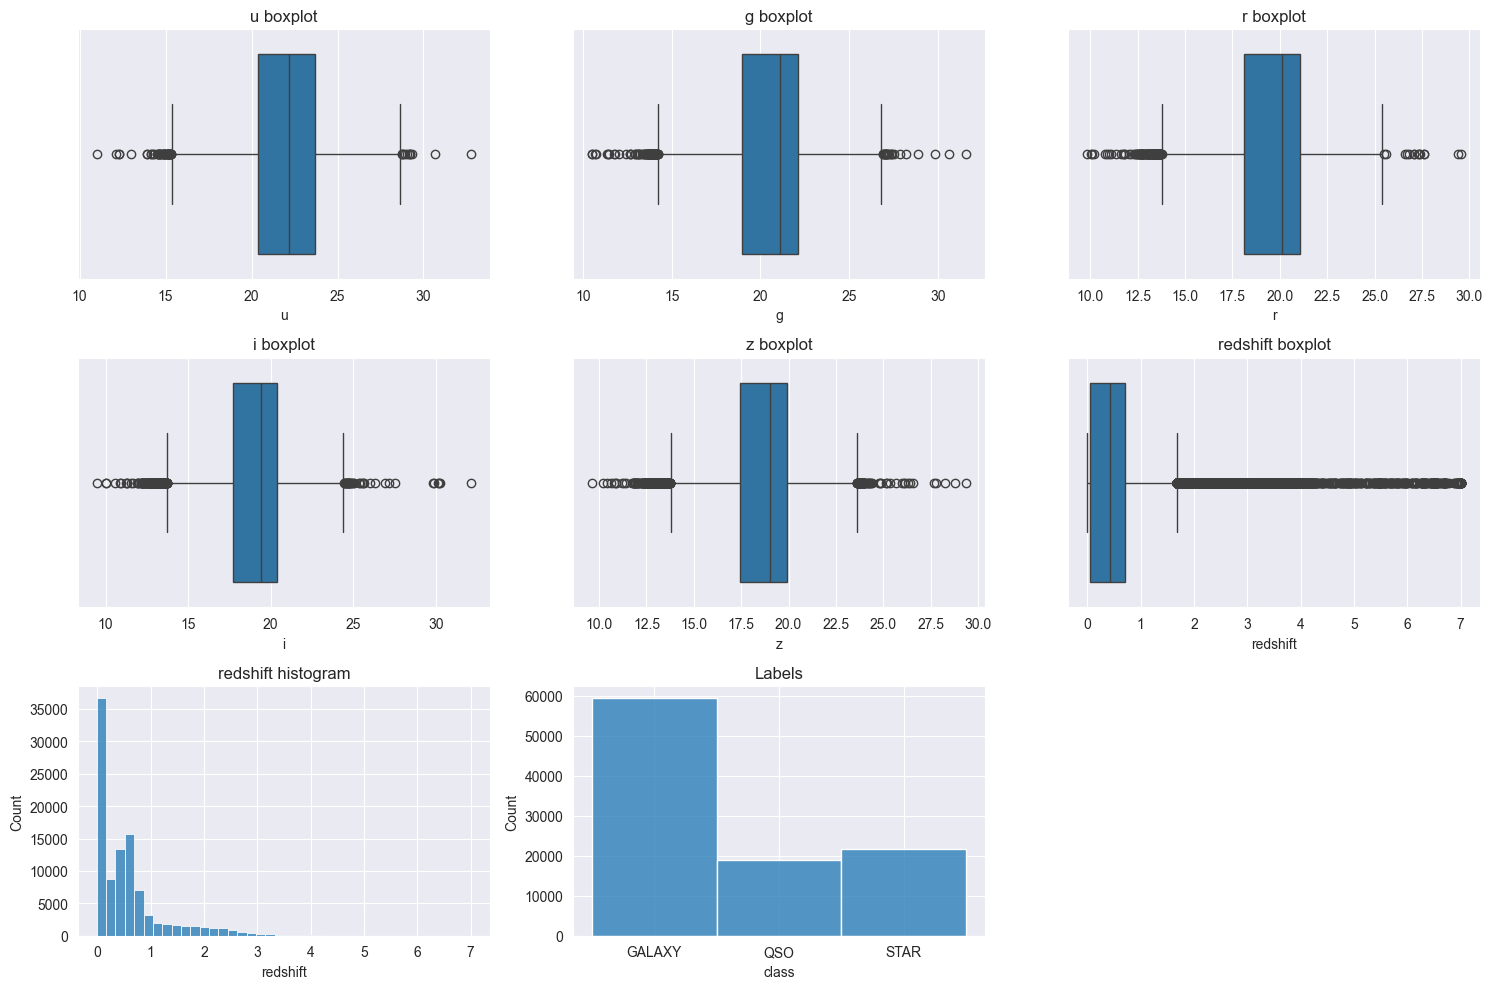

In [5]:
features = ['u', 'g', 'r', 'i', 'z', 'redshift']
cleaned_features = ['u', 'g', 'z']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(features):
    ax = axes[idx]
    col_data = data[col]
    if col in cleaned_features:
        col_data = col_data[col_data != -9999.0]
    sns.boxplot(x=col_data, ax=ax)
    ax.set_title(f'{col} boxplot')
    
sns.histplot(x=data['redshift'], ax=axes[len(features)], bins=40)
axes[len(features)].set_title('redshift histogram')

sns.histplot(x=data['class'], ax=axes[len(features)+1], bins=3)
axes[len(features)+1].set_title('Labels')

axes[-1].axis('off')

plt.tight_layout()
plt.show()


As part of the exploratory data analysis, we can also display the correlation matrix, showing levels of correlations between all features and labels

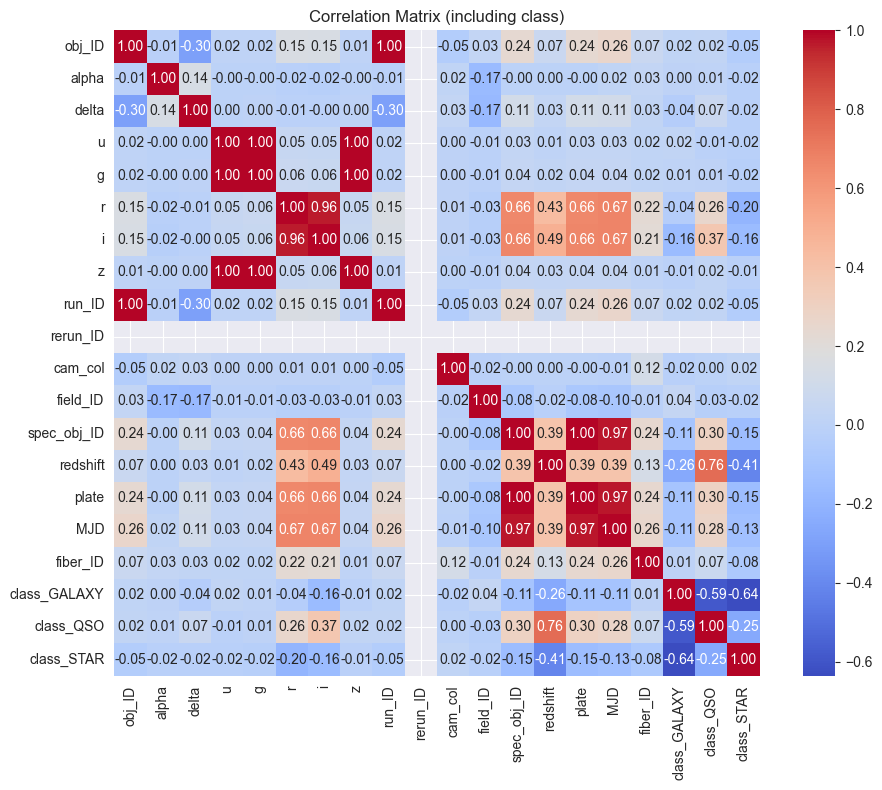

In [6]:
data_copy = data.copy()
data_copy = pd.get_dummies(data_copy, columns=['class'])  # allows us to show correlation for all three labels separately

corr_matrix = data_copy.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix (including class)')
plt.tight_layout()
plt.show()


## Data cleaning

From the previous exploration it has emerged that a single row constitutes an outlier and is likely erroneous. As such we drop it and check that its removal constitutes the loss of outliers for all interested columns

In [7]:
ind = data.index[data['u'] == -9999.0]
data.drop(index=ind, inplace=True)

data['u'].min(), data['g'].min(), data['z'].min()

(np.float64(10.99623), np.float64(10.4982), np.float64(9.612333))

## Data transformation pipeline

Now we can take care of the preprocessing steps, given the information gathered in the exploration. They are as follows:
- obj_ID, spec_obj_ID: **drop** as they are just identifiers for the celestial object
- alpha, delta: **normalize** as they are bounded and might have clustered values
- u, g, z: **drop the 1 error value** and **standardize** as magnitude is logarithmic and normalization follow a linear scale and as they have many outliers
- r, i: **standardize** as it's once again a magnitude
- run_ID, rerun_ID, cam_col, field_ID: **drop** as they are just metadata 
- class: rendering the nominal difference numerical and **oversampling or undersampling**
- redshift: **standardize** as it has a lot of outliers
- plate, MJD: either **keep as is or drop** depending on the results of testing

We can thus proceed with the creation of the transformation pipeline to solve the previously highlighted issues

In [8]:
X = data.drop('class', axis=1)
y = data['class']
y = y.map({'GALAXY':0, 'STAR':1, 'QSO':2})

In [9]:
final_transformation = ColumnTransformer(transformers=[
    ('metadat', 'drop', ['obj_ID', 'spec_obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID']),
    ('alpha_delta', MinMaxScaler(), ['alpha', 'delta']),
    ('spectrum', StandardScaler(), ['u', 'g', 'z', 'r', 'i', 'redshift'])
],
remainder='passthrough',  # for the time being we pass through "plate" and "MJD" because they seemed interesting in the correlation matrix 
verbose_feature_names_out=False,
sparse_threshold=0
)

## Training and testing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0, shuffle=True)

### Model selection

In [11]:
# the transformations are applied only once, outside the model pipeline because the df has 9999 rows
X_train = final_transformation.fit_transform(X_train)
X_test = final_transformation.transform(X_test)

# we define the model pipeline with placeholder arguments
model_pipeline = IMBPipeline([
    ('sampler', RandomUnderSampler()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron()),
])

In [12]:
type(X_train)

numpy.ndarray

Now we can perform a sanity check

In [23]:
model_pipeline.fit(X_train, y_train)

np.set_printoptions()
prediction = model_pipeline.predict(X_test)
prediction

array([1, 1, 2, ..., 2, 1, 2])

In [17]:
assert len(prediction) == X_test.shape[0]  #ensure that the number of predictions matches the number of test samples


In [65]:
np.unique(prediction)

array([1, 2])

everything seems in order, let us move on. We will devise a list of all the possible configurations for resampling dimensionality reduction, and classificators, to test in our CV. Here's all of them

```python
sampler_configs = [
    {'sampler': [None]},
    
    {'sampler': [SMOTE()],
     'sampler__sampling_strategy': ['auto', 'not majority', 'not minority', 'all']},
    
    {'sampler': [RandomOverSampler()],
     'sampler__sampling_strategy': ['auto', 'not majority', 'not minority', 'all'],},
    
    {'sampler': [RandomUnderSampler()],  # worth trying as the df is medium-large
     'sampler__sampling_strategy': ['auto', 'not majority', 'not minority', 'all']},
    
    {'sampler': [ADASYN()],  # worth trying as the df is multiclass
     'sampler__sampling_strategy': ['auto', 'not majority', 'not minority', 'all']}
]


dim_reduction_configs = [
    {'dim_reduction': [None]},
    
    {'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]},
    
    {'dim_reduction': [KernelPCA()],  # worth trying as it helps with non-linear relationships, such as between brightness magnitude and redshift
    'dim_reduction__n_components': [1], #, 5, 11],
    'dim_reduction__kernel': ['rbf']}, #, 'poly']},
    
    {'dim_reduction': [LDA()]},
    
    {'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1_macro')],
     'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
     'dim_reduction__k_features' : [5,7,9]},
    
{'dim_reduction': [FeatureAgglomeration()],  # worth trying as the majority of the features are brightness in different ranges of light, and thus correlated
    'dim_reduction__n_clusters': [5, 7, 9],
    'dim_reduction__linkage': ['ward', 'complete', 'average']}
]


classifier_configs = [
    {'classifier': [Perceptron()],
     'classifier__eta0' : loguniform(0.001,100),
     'classifier__max_iter': [30, 50, 60, 80, 100] ,
     'classifier__class_weight' : [None, 'balanced']},
    
    {'classifier': [LogisticRegression(solver='saga')],
     'classifier__C' : loguniform(0.001,100),
     'classifier__penalty': ['l1','l2'],
     'classifier__class_weight' : [None, 'balanced']},
    
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [3,5,7,9]},
    
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : [10,50,100, 500]},

    {'classifier': [DecisionTreeClassifier()],
     'classifier__max_depth': [None, 10, 20, 50, 100],
     'classifier__min_samples_split': [2, 5, 10, 20, 50],
     'classifier__min_samples_leaf': [2, 4, 10, 20, 50],
     'classifier__class_weight': [None, 'balanced']},
    
    {'classifier': [XGBClassifier()],
     'classifier__n_estimators': [50, 100, 200],
     'classifier__learning_rate': loguniform(0.001, 0.3),
     'classifier__max_depth': [3, 6, 10, 50, 100],
     'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
     'classifier__colsample_bytree': [0.8, 0.9, 1.0]},
    
    {'classifier': [SVC()],
     'classifier__C': loguniform(0.01, 100),
     'classifier__kernel': ['linear', 'rbf'],
     'classifier__gamma': ['scale', 'auto'],
     'classifier__class_weight': [None, 'balanced']}
]
```

The list is, however, far too long as it presents 175 configuration types, requiring - based on limited testing - upwards of two days of computation time. Our goal is to reduce it to a workable length, specifically something with a computation time of less than 8 hours, as that's the [time limit for Deepnote](https://deepnote.com/docs/long-running-jobs).
As such we will start removing candidates a priori, based on a theoretical analysis, but followed by testing. We do acknowledge that the testing lacks in reliability as not all variables and conditions can be controlled at the same time.
Quick tests using the K neighbours classifier and a grid search shown below, were conduced to assess the performance of the other transformers.

```python
gs = GridSearchCV(
    model_pipeline,
    param_grid=all_configs,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
```


#### Samplers

We elected to remove the random oversampler as it seemed to have the worst performance across the board, and considering that SMOTE is already an oversampler, but with more sophisticated techniques. Furthermore, we also removed ADASYN as its main mechanism of action is that of adding synthetic samples near decision boundaries and, as we will discuss below, in this case specifically this might be ill-advised.

SMOTE +2 -0.03
RANDOM OVER +O.1 -0.05
UNDER -0.3 -0.01
ADASYN +1  -0.05



#### Dimensionality reduction

Kernel PCA was removed as it required far more memory than available due to the construction of multiple similarity matrices. Furthermore, it was found that SFS and LDA gave by far the best improvements suggesting that the df might have redundant features and that once they key features are either selected or combined, they might be relatively linearly separable. As such we remove also PCA and Feature agglomeration as they are less apt to find discriminative features.

PCA -0.5 -0.04
LDA -0.3 +0.3
SFS +30  +0.4
FEATURE AGG +0.8 +0.01

#### Classifiers

The support vector classificator was removed as it had higher time requirements than all other candidates - order of magnitude higher -, and did not show promising results. Furthermore, due to the insight gained by the dimensionality reduction, we elected to remove the KNN as it is sensitive to irrelevant features, given it is a lazy learner.

prerceptron 1s, 0.35
log reg 4s, 0.31
knn 1s, 0.56
randomforest 37s, 0.97
decision tree 3s 0.96
xgb 2s 0.97
svc 3m 0.3

At this point multiple runs were tried with the remaining estimators, but the size of the configurations sampled, i.e. ten times the amount of configuration types, remained far too vast, causing numerous problems and prematurely ending every run. As such a smaller exploratory version, with sample size of about 25% the desired one, was performed, gaining the following insight: the random forest tree classifier was the best performing model, and the winning configuration used undersampling, and no dimensionality reduction technique. We interpret this, in relation to the previous result about the importance of LDA and SFS for simpler models, to mean that in our df the core signal is relatively linearly separable, but obscured by noise or irrelevant features.

This, alongside our need to reduce computation time, brought us to choosing to remove the XGB classifier, as well as the decision tree. The choice comes mainly from the fact that they are both based on a tree structure, like the random forest, yet they perform worse; furthermore, they are both prone to overfitting, something already noticed in the random forest. Finally, the complexity of XGB as a model, specifically w.r.t. its underwhelming performance, indicates that it is unsuited for either the kind of data used, or the type of exploration we performed, and as such a properly implemented version is outside the scope of this project.

The final configuration types list is then as follows:

In [66]:
sampler_configs = [
    {'sampler': [None]},
    
    {'sampler': [SMOTE()],
     'sampler__sampling_strategy': ['auto', 'not majority', 'not minority', 'all']},
    
    {'sampler': [RandomUnderSampler()],
     'sampler__sampling_strategy': ['auto', 'not majority', 'not minority', 'all']}
]


dim_reduction_configs = [
    {'dim_reduction': [None]},
    
    {'dim_reduction': [LDA()]},
    
    {'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1_macro')],
     'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
     'dim_reduction__k_features' : [3,5,7,9]},
]


classifier_configs = [
    {'classifier': [Perceptron()],
     'classifier__eta0' : loguniform(0.001,100),
     'classifier__max_iter': [30, 50, 60, 80, 100] ,
     'classifier__class_weight' : [None, 'balanced']},
    
    {'classifier': [LogisticRegression(max_iter=2000)],
     'classifier__solver': ['saga', 'lbfgs'],
     'classifier__C' : loguniform(0.001,100),
     'classifier__penalty': ['l1','l2'],
     'classifier__class_weight' : [None, 'balanced']},
    
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : [10,50,100,500]}
]

Before creating the configuration list, it is worth acknowledging how it is now clear that the size of the df chosen is incompatible with the degree of exploration initially desired, due to hardware limitations. As such, considering how the ultimate goal of the project is not that of obtaining a model that can be professionally applied in the field of star classification, but rather understanding how one such model is created through all the necessary processes, another viable strategy could have been that of significantly reducing the size of the df in order to perform a more satisfactory exploration of possible configurations, or changing it altogether. This, however, exists as a possibility solely due to the fact that the project is an academic exercise, and would not be reasonable in any other context.

In [67]:
all_configs = []
for configuration in itertools.product(sampler_configs, dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters))

In [68]:
# all_configs  # only used to better understand the creation of the list from the merging of the dictionaries

In [69]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 27'

Finally, we can proceed with the CV

In [70]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs)*10,
    n_jobs=1,
    cv = 5,
    scoring='f1_macro',
    random_state=42
)

During testing, obtaining consistent results and being able to access them became decisive in the understanding of the characteristics of the chosen configuration. As suc random state attributes were used and the code below was implemented to display the results:


```python
from sklearn.model_selection import ParameterSampler

param_list = list(ParameterSampler(param_distributions=all_configs, n_iter=10, random_state=42))

for i, params in enumerate(param_list):
    print(f"Iteration {i+1} - Selected Params:")
    print(params)
    print("---")
```


In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='f1_macro', cv = 5, return_estimator=True, verbose=3, error_score='raise')

Since running the full version will take multiple hours, and the project will thus be run unsupervised, we save the result to disk, so as to preserve them in case the platform gets shut off due to inactivity

In [89]:
with open("cv_results.pkl", "wb") as f:
    pickle.dump(scores, f)
print("cross-validation results saved.")

Cross-validation results saved.


In [72]:
with open("cv_results_upload.pkl", "rb") as f:
    scores = pickle.load(f)

In [73]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomUnderSampler(sampling_strategy='not majority')
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.974318284061591
----------
None
None
RandomForestClassifier() {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.975

for better generalization we use also PR AUC alongside f1 as it generalizes the precision-recall ratio to all thresholds levels

In [74]:
# we binarize the labels through one-hot encoding, as AUC has one-vs-rest approach 
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

winner_index = None
highest_score = None

for i, estimator in enumerate(scores['estimator']):
    model = estimator.best_estimator_
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # we generate weighted scores as we want our performance metrics to generalize well across all classes, no matter their size, given the class imbalance
    f1_train = f1_score(y_train, pred_train, average="weighted")
    f1_test = f1_score(y_test, pred_test, average="weighted")
    
    # since AUC requires continuous scores, we check if the model has one we can use
    if hasattr(model, "predict_proba"):
        y_train_scores = model.predict_proba(X_train)
        y_test_scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):  # we allow for AUC based on different metrics as they are comparable
        y_train_scores = model.decision_function(X_train)
        y_test_scores = model.decision_function(X_test)
    else:
        # if it can't be computed we simply print that and go to the next
        print(f"Model {i} does not support probability scores for PR AUC.")
        y_train_scores = None
        y_test_scores = None
    
    if y_train_scores is not None:
        pr_auc_train = average_precision_score(y_train_bin, y_train_scores, average="macro")  # we use macro rather than weighted as it can hide poor performance on minority classes if the majority dominates.
        pr_auc_test = average_precision_score(y_test_bin, y_test_scores, average="macro")
    else:
        pr_auc_train = None
        pr_auc_test = None
    
    print(f"Model: {i}")
    print(f"F1 weighted train: {f1_train:.4f}, test: {f1_test:.4f}")
    if pr_auc_train is not None:
        print(f"PR AUC (macro) train: {pr_auc_train:.4f}, test: {pr_auc_test:.4f}")
    print("-" * 40)
    
    # determines the best candidate automatically in case the user does not want to choose
    if highest_score is None:
        winner_index = i
        highest_score = (f1_test+pr_auc_test)/2 if pr_auc_test is not None else f1_test
    elif ((f1_test+pr_auc_test)/2 if pr_auc_test is not None else f1_test) >= highest_score:
        winner_index = i
        highest_score = (f1_test+pr_auc_test)/2 if pr_auc_test is not None else f1_test

Model: Pipeline
F1 weighted train: 1.0000, test: 0.9787
PR AUC (macro) train: 1.0000, test: 0.9906
----------------------------------------
Model: Pipeline
F1 weighted train: 1.0000, test: 0.9776
PR AUC (macro) train: 1.0000, test: 0.9894
----------------------------------------


At this point a we have 5 candidates all with high and similar performances. The choice of final model is thus not automatized, rather left to the user. We do, however, provide a commented-out version to automatically chose the best candidate, in case the random seed was removed.


In [75]:
best_estimator = scores['estimator'][winner_index]

#best_estimator = scores['estimator'][input('insert index of desired model: ')]

best_estimator

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                             ('dim_reduction',
                                              PCA(n_components=0.8)),
                                             ('classifier', Perceptron())]),
                   n_iter=270, n_jobs=-1,
                   param_distributions=[{'classifier': [Perceptron()],
                                         'classifier__class_weight': [None,
                                                                      'balanced'],
                                         'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object a...
                                                                      100,
                                                                      500],
                                         'dim_reduction': [SequentialFeatureSelector(cv=None,
                                                                                     estimator=Perceptron(),
                                                                                     scoring='f1_macro')],
                                         'dim_reduction__estimator': [Perceptron(),
                                                                      LogisticRegression()],
                                         'dim_reduction__k_features': [3, 5, 7,
                                                                       9],
                                         'sampler': [RandomUnderSampler()],
                                         'sampler__sampling_strategy': ['auto',
                                                                        'not '
                                                                        'majority',
                                                                        'not '
                                                                        'minority',
                                                                        'all']}],
                   random_state=42, scoring='f1_macro')

Now we can visualize the performance of ou model with a confusion matrix

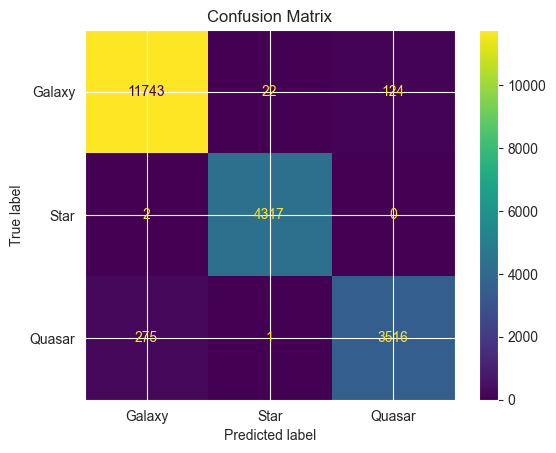

In [76]:
y_true = y_test
y_pred = best_estimator.predict(X_test)

cm = confusion_matrix(y_true, y_pred)
class_names = ['Galaxy', 'Star', 'Quasar']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

## Refinement of the selected model

Now that we have our best performing model, we rerun a CV to identify the best configuration possible. As such the pipeline must be defined.

In order to individuate the ranges of the parameters we want to explore, we print to screen the current ones: 

In [130]:
classifier = best_estimator.best_estimator_.get_params()['classifier']

def print_attributes(c):
    tree_depths = [est.tree_.max_depth for est in c.estimators_]  # depths of each tree in the forest
    
    info = [
        f"Average tree depth: {sum(tree_depths) / len(tree_depths):.2f}",
        f"Max tree depth: {max(tree_depths)} \n"
        f'Number of trees: {len(classifier.estimators_)} \n'  # number of trees trained
        f'N. of samples for split: {classifier.min_samples_split} \n'  # minimum number of samples required to split an internal node.
        f'N. of samples for leaf: {classifier.min_samples_leaf} \n'  # minimum number of samples required to be a leaf
    ]
    
    for piece in info:
        print(piece)

print_attributes(classifier)

Average tree depth: 30.43
Max tree depth: 41 
Number of trees: 500 
N. of samples for split: 2 
N. of samples for leaf: 1 



In [110]:
n_iter = 40

best_model_pipeline = IMBPipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

params = {
    'classifier__n_estimators': [randint(400, 600) for _ in range(n_iter)],
    'classifier__max_depth': [10, 30, 50, None],
    'classifier__min_samples_split': [2, 5, 7],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42),
    n_iter=n_iter,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

In [113]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [10, 30, 50,
                                                                  None],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          7],
                                        'classifier__n_estimators': [424, 555,
                                                                     426, 435,
                                                                     498, 592,
                                                                     571, 483,
                                                                     436, 499,
                                                                     594, 559,
                                                                     478, 518,
                                                                     489, 433,
                                                                     552, 534,
                                                                     474, 547,
                                                                     517, 404,
                                                                     477, 520,
                                                                     446, 467,
                                                                     477, 450,
                                                                     531, 547, ...]},
                   random_state=42, scoring='f1')

In [114]:
with open("TUNING_results.pkl", "wb") as f:  # once again we saved the result to disk given the time needed
    pickle.dump(scores, f)
print("cross-validation results saved.")

cross-validation results saved.


### Analyzing performance

In [131]:
# we display the final parameters values
tuned_classifier = rs_best.best_estimator_.get_params()['classifier']

print_attributes(classifier)

Average tree depth: 10.00
Max tree depth: 10 
Number of trees: 436 
N. of samples for split: 5 
N. of samples for leaf: 2 



 we can now analyze bias–variance trade-off using learning curves and validation curves:

In [144]:
f1_train_tuned = f1_score(y_test, rs_best.best_estimator_.predict(X_test), average='weighted')
f1_test_tuned = f1_score(y_train, rs_best.best_estimator_.predict(X_train), average='weighted')

print(f"F1 weighted train: {f1_train_tuned:.4f}, test: {f1_test_tuned:.4f}")

F1 weighted train: 0.9758, test: 0.9817


We can see that after the tuning the model no longer has 100% f1 score in the training data, suggesting we reduced the variance; more precisely we can produce the learning and validation curves:

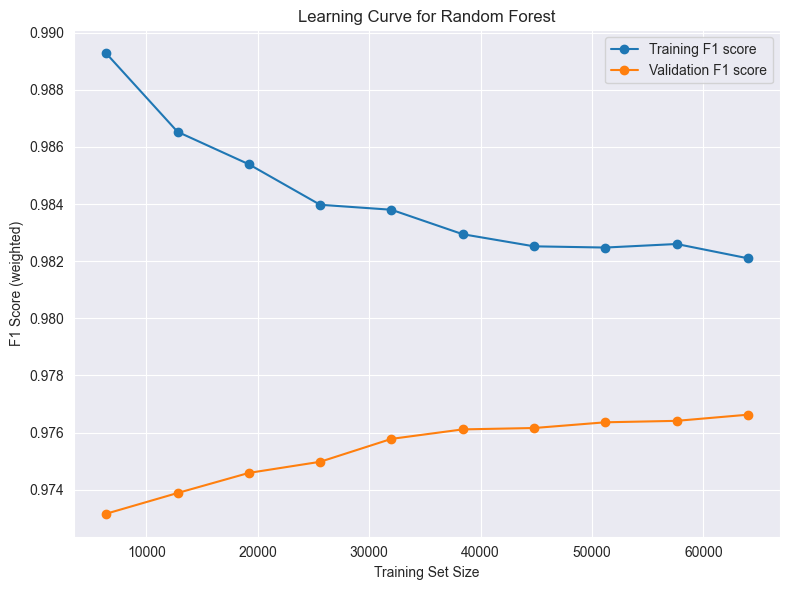

In [133]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=rs_best.best_estimator_,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training F1 score')
plt.plot(train_sizes, valid_scores_mean, 'o-', label='Validation F1 score')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score (weighted)')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Here we can see the training and validation curves converge, meaning the model has a good balance between bias and variance. It performs well on both the training and validation sets, suggesting it generalizes well to new, unseen data.

Next, given how the previous highest performing models had high variance in number of estimators, and that once tuned the best model had very different depth from its original value, we can plot the score they generate against their values, in the following validation curve plots:

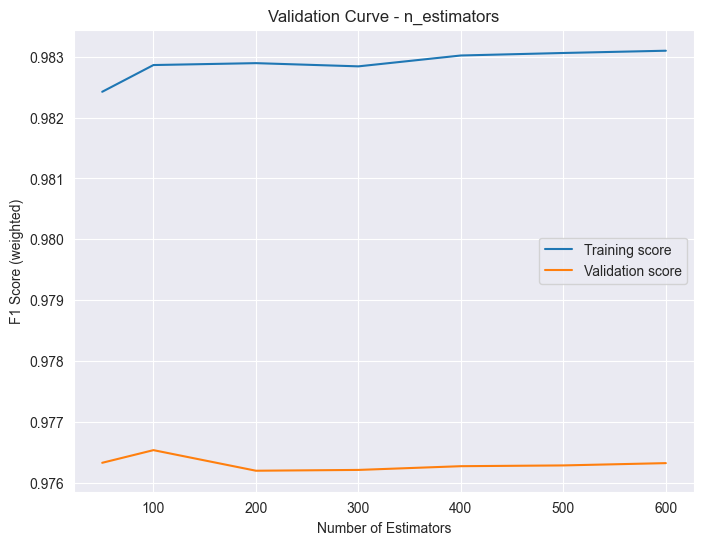

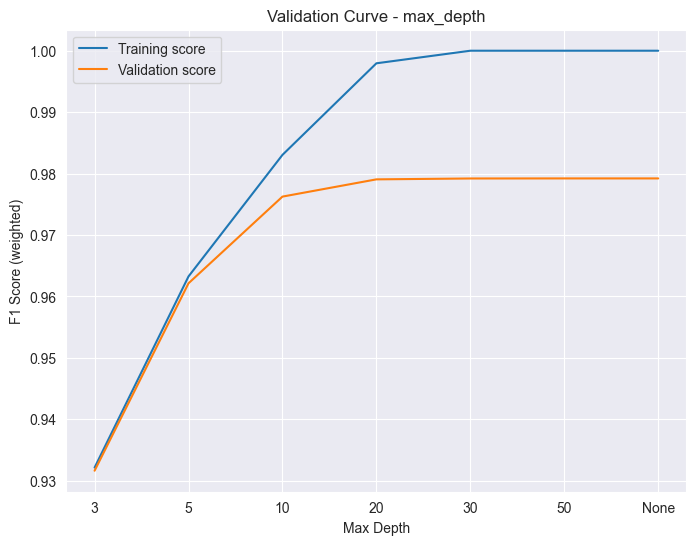

In [135]:
# validation curve for number of estimators
param_range_estimators = [50, 100, 200, 300, 400, 500, 600]
train_scores, test_scores = validation_curve(
    estimator=RandomForestClassifier(max_depth=rs_best.best_estimator_.named_steps['classifier'].max_depth, random_state=42),
    X=X_train,
    y=y_train,
    param_name="n_estimators",
    param_range=param_range_estimators,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range_estimators, train_mean, label="Training score")
plt.plot(param_range_estimators, test_mean, label="Validation score")
plt.xlabel("Number of Estimators")
plt.ylabel("F1 Score (weighted)")
plt.title("Validation Curve - n_estimators")
plt.legend()
plt.grid(True)
plt.show()


# validation curve for depth
param_range_depth = [3, 5, 10, 20, 30, 50, None]
train_scores, test_scores = validation_curve(
    estimator=RandomForestClassifier(n_estimators=rs_best.best_estimator_.named_steps['classifier'].n_estimators, random_state=42),
    X=X_train,
    y=y_train,
    param_name="max_depth",
    param_range=param_range_depth,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot([str(p) for p in param_range_depth], train_mean, label="Training score")
plt.plot([str(p) for p in param_range_depth], test_mean, label="Validation score")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score (weighted)")
plt.title("Validation Curve - max_depth")
plt.legend()
plt.grid(True)
plt.show()


Regarding the former plot we can notice how the validation score seems to peak at 100, levelling off as the number keeps increasing; simultaneously the training score also has a peek at 100, but then keeps increasing, albeit slowly. This suggests that the ideal number of estimators is around 100, with higher and higher amounts causing an increasing in variance and possibly overfitting.

As such our model could have probably benefited from a lower number of estimators, though the gains would have been primarily in resource expenditure - or lack thereof - rather than in actual score, as the difference is minimal.


As far the latter goes, on the other hand, we can see that both curves follow the same trajectory, completely leveling off at 20 nodes of depth where, however, the training scores dramatically increases. Given our model's final depth was 10, we can determine the CV favoured a more moderate approach aimed at better global generalization, as the slight increase in validation score it could have obtained with greater depths would have come at the cost of significant higher variance.

---

Finally, given we used a correlation matrix during the exploratory data analysis, we might be compelled to discover which features were the most important ones. As such we can plot the importance barplot

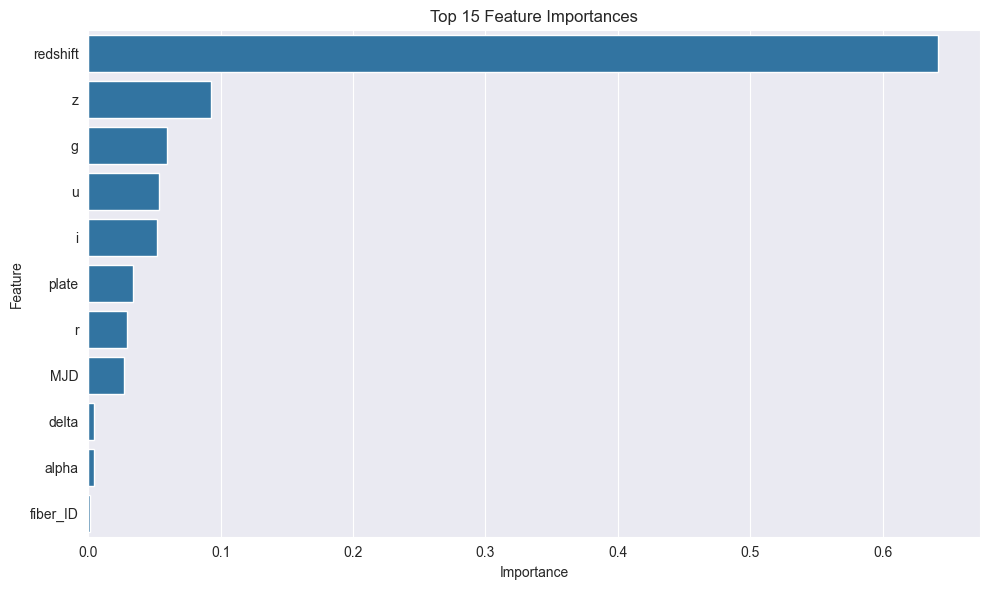

In [146]:
importances = rs_best.best_estimator_.named_steps['classifier'].feature_importances_
features = final_transformation.get_feature_names_out()
feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values[:15], y=feat_importances.index[:15])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


As we could see from the correlation matrix, redshift had by far the highest importance, quickly followed by all the spectroscopy data. Interestingly enough, both plate and MJD did play a moderate role in classification, which validates our initial choice of leaving them, through the "passthrough" parameter 

## Conclusion



The final Random Forest model achieved strong predictive performance while maintaining generalizability, as evidenced by consistent validation scores and moderate model complexity. Analysis of the learning and validation curves indicated a well-balanced bias-variance trade-off. Overall, the model demonstrates reliability for multi-class classification in the presence of imbalanced data.